<a href="https://colab.research.google.com/github/nice-digital/nice-ds-kidneycancer/blob/master/kidneycancer/code/topicmodel_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Topic modelling on pre-processed dataset (Kidney cancer)**

This Colab notebook creates topic models on pre-processed datasets


**Inputs**
- Data file: Please note that the input data file should be the output of preproc colab or categorisation colab. Name your input file *input_data.csv*.

**Outputs**

- The interactive plots is a key output, as well as the excel spreadsheet produced process_model.csv in Results folder which provides information on the best topic associated with each study.

Upload the input file  by pressing the upload button on the top left of the left sidebar. The results will appear in a folder named *RESULTS*. RESULTS folder will be automatically created by the code

In [46]:
#@title Install Python packages { form-width: "20%" }

#@markdown Please execute this cell by pressing the _Play_ button
#@markdown on the left to download and import third-party software
#@markdown in this Colab notebook.

#@markdown This installs the software on the Colab
#@markdown notebook in the cloud and not on your computer.
!pip install --upgrade pip
from IPython.utils import io
import subprocess

try:
  with io.capture_output() as captured:
    %shell pip install pyLDAvis==3.3.1
    %shell pip install import-ipynb
    %shell pip install pandas
    %shell pip install shutup

except subprocess.CalledProcessError:
  print(captured)
  raise
import shutup
shutup.please()

import os
import numpy as np
import pandas as pd
from pathlib import Path

from gensim.corpora import Dictionary
from gensim.models import LdaModel
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()


pd. set_option('display.max_colwidth', None)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [47]:
#@title File settings to get started { form-width: "20%" }

#@markdown Please ensure the input_data.csv is uploaded and execute this cell by pressing the _Play_ button
#@markdown on the left
DATA_PATH = 'input_data.csv'

results_folder = 'RESULTS'
RESULTS_FOLDER = results_folder     #***user input
if not os.path.isdir(RESULTS_FOLDER):
    os.makedirs(RESULTS_FOLDER)
RESULTS_PATH = Path(RESULTS_FOLDER)

In [48]:
#@title Read input file  { form-width: "20%" }

def handle_listStrings(list_tokens):
  return(eval(list_tokens))

lit_data = pd.read_csv('input_data.csv')
#lit_data = df.loc[df['include'] > 0] # for kidneys dont need include line


lit_data['medTokens'] = lit_data.medTokens.apply(handle_listStrings)
lit_data['cancerTokens'] = lit_data.cancerTokens.apply(handle_listStrings)
lit_data['entTokens'] = lit_data.entTokens.apply(handle_listStrings)

In [4]:
lit_data.shape[0]

4334

In [49]:
#@title Function definitions for LDA model results { form-width: "20%" }

#@markdown Please execute this cell by pressing the _Play_ button on the left

from matplotlib import pyplot as plt
from wordcloud import WordCloud
import matplotlib.colors as mcolors
from math import ceil
from collections import Counter

def get_document_topic_table(lda_model, corpus):
  # Init output
  document_topic_df = pd.DataFrame()

  # Get main topic in each document
  for i, row_list in enumerate(lda_model[corpus]):   #i - abstract number, row_list: topic number and probability
    row = sorted(row_list, key=lambda x: (x[1]), reverse=True)
    topic_num=row[0][0]
    prop_topic=row[0][1]
    wp = lda_model.show_topic(topic_num)
    topic_keywords = ", ".join([word for word, prop in wp])
    document_topic_df.at[i,'best_topic']=topic_num
    document_topic_df.at[i,'prop_topic']=prop_topic
    document_topic_df.at[i,'topic_keywords']=topic_keywords
    document_topic_df.at[i,'document_num']=i
    document_topic_df.at[i,'topic_dist'] = str(row)

  return document_topic_df

def model_lda(dict, corpus):
  # Build LDA model
  lda_model = LdaModel(corpus=corpus, id2word=dict, num_topics=NUM_TOPICS, random_state=100,
                chunksize=200, passes=100)
  print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

  print("***Word distribution in topics***")
  lda_model.print_topics()[:NUM_TOPICS-1]


  return lda_model

def show_wordcloud(lda_model):
  cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

  cloud = WordCloud(background_color='white',
                  width=2500,
                  height=1800,
                  max_words=30,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)
  topics = lda_model.show_topics(formatted=False)
  ncol = 2
  nrow = ceil(NUM_TOPICS/ncol)
  fig, axes = plt.subplots(nrow, ncol, figsize=(10,10), sharex=True, sharey=True)

  for i, ax in enumerate(axes.flatten()):
    ax.set_axis_off()
    if i == NUM_TOPICS:
      break
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')
    # ax.set_axis_on()


  plt.subplots_adjust(wspace=0, hspace=0)
  plt.axis('off')
  plt.margins(x=0, y=0)
  plt.tight_layout()
  plt.show()


def show_wordimportance(lda_model, data):
  topics = lda_model_med.show_topics(formatted=False)
  data_flat = [w for w_list in data for w in w_list]
  counter = Counter(data_flat)
  out = []

  for i, topic in topics:
    for word, weight in topic:
      out.append([word, i , weight, counter[word]])

  df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])
  ncol = 2
  nrow = ceil(NUM_TOPICS/ncol)

  # Plot Word Count and Weights of Topic Keywords
  fig, axes = plt.subplots(nrow, ncol, figsize=(16,20), sharey=True,dpi=160)
  cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
  for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.5); ax.set_ylim(0, 1000)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

  fig.tight_layout(w_pad=5)


In [62]:
#@title Specify number of topics  { form-width: "20%" }

#@markdown Please execute this cell by pressing the _Play_ button on the left

NUM_TOPICS = 4

In [37]:
#@title Specify exclusions { form-width: "20%" }

# Below are the list of irrelevant words for medical entity model
#MED_IRRELEVANT = ['Cancer', 'cancer', 'Cancers', 'cancers' 'Kidney cancer', 'kidney cancer', 'Kidney cancers', 'kidney cancers', 'renal cell carcinoma', 'objective(s', 'purpose(s', 'tumor(s', 'tumour(s' 'patients','patient', 'kidney cancer patients']

In [63]:
CANCER_TERMS = ['Cancer', 'Cancers', 'Kidney', 'Kidneys', 'Renal',
                'Prostate cancer', 'Breast cancer', 'Kidney cancer', 'Prostate cancers', 'Breast cancers', 'Kidney cancers',
                'Renal cell carcinoma', 'Acute kidney injury', 'Tumour', 'Tumor', 'Renal cell carcinomas', 'Acute kidney injuries', 'Tumours', 'Tumors',
                'Patient', 'Objective', 'Purpose', 'Patients', 'Objectives', 'Purposes']

def make_lower_list(word_list):
  lower_words = [x.lower() for x in word_list]
  return word_list + lower_words

MED_IRRELEVANT = make_lower_plural_list(CANCER_TERMS)

In [64]:
#@title LDA modelling on med tokens  { form-width: "20%" }
DATA = lit_data["medTokens"]
DATA = DATA.apply(lambda x: [y for y in x if y not in MED_IRRELEVANT])

DICTIONARY = Dictionary(DATA)
# Bag-of-words representation of the documents.
CORPUS = [DICTIONARY.doc2bow(doc) for doc in DATA]
lda_model_med = model_lda(DICTIONARY, CORPUS)

document_topic_df = get_document_topic_table(lda_model=lda_model_med, corpus=CORPUS)
lit_data.reset_index(drop=True, inplace=True)
document_topic_df.reset_index(drop = True, inplace=True)
out_df = pd.concat([lit_data, document_topic_df], axis = 1)
out_df.to_csv(RESULTS_PATH / "processed_model.csv", index=False)

lda_model_med.print_topics()[:NUM_TOPICS]



Perplexity:  -7.083899314389403
***Word distribution in topics***


[(0,
  '0.048*"death" + 0.021*"pain" + 0.021*"infection" + 0.021*"renal cell cancer" + 0.016*"calcium" + 0.015*"colorectal cancer" + 0.012*"infections" + 0.012*"inflammation" + 0.012*"melanoma" + 0.011*"gastric cancer"'),
 (1,
  '0.031*"toxicity" + 0.030*"sunitinib" + 0.027*"hypertension" + 0.025*"tyrosine" + 0.018*"cisplatin" + 0.017*"heart failure" + 0.016*"rapamycin" + 0.016*"everolimus" + 0.015*"sorafenib" + 0.013*"axitinib"'),
 (2,
  '0.064*"diabetes" + 0.049*"chronic kidney disease" + 0.030*"obesity" + 0.021*"creatinine" + 0.021*"cardiovascular disease" + 0.019*"renal cancer" + 0.019*"hypertension" + 0.018*"diabetes mellitus" + 0.012*"renal tumors" + 0.012*"stroke"'),
 (3,
  '0.029*"malignancy" + 0.029*"vitamin d" + 0.026*"bladder cancer" + 0.024*"carcinoma" + 0.017*"tract urothelial carcinoma" + 0.017*"bleeding" + 0.015*"sarcopenia" + 0.012*"metformin" + 0.011*"urothelial carcinoma" + 0.011*"prostate"')]

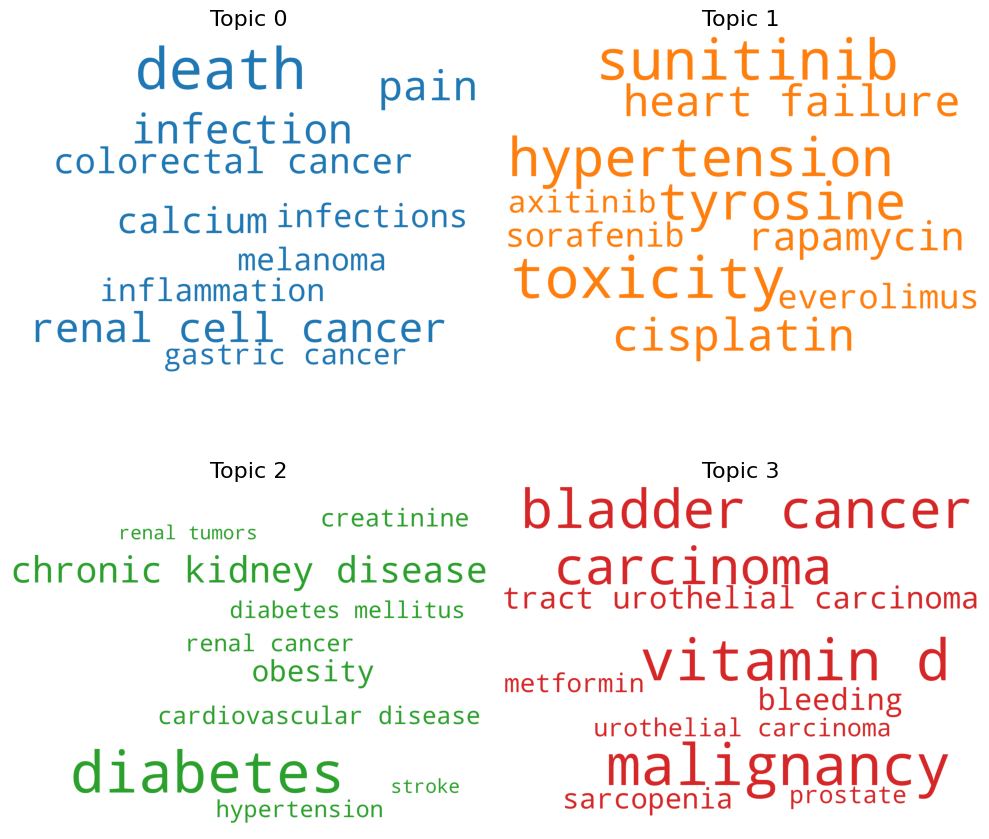

In [65]:
#@title Word cloud of topics  { form-width: "20%" }
show_wordcloud(lda_model_med)

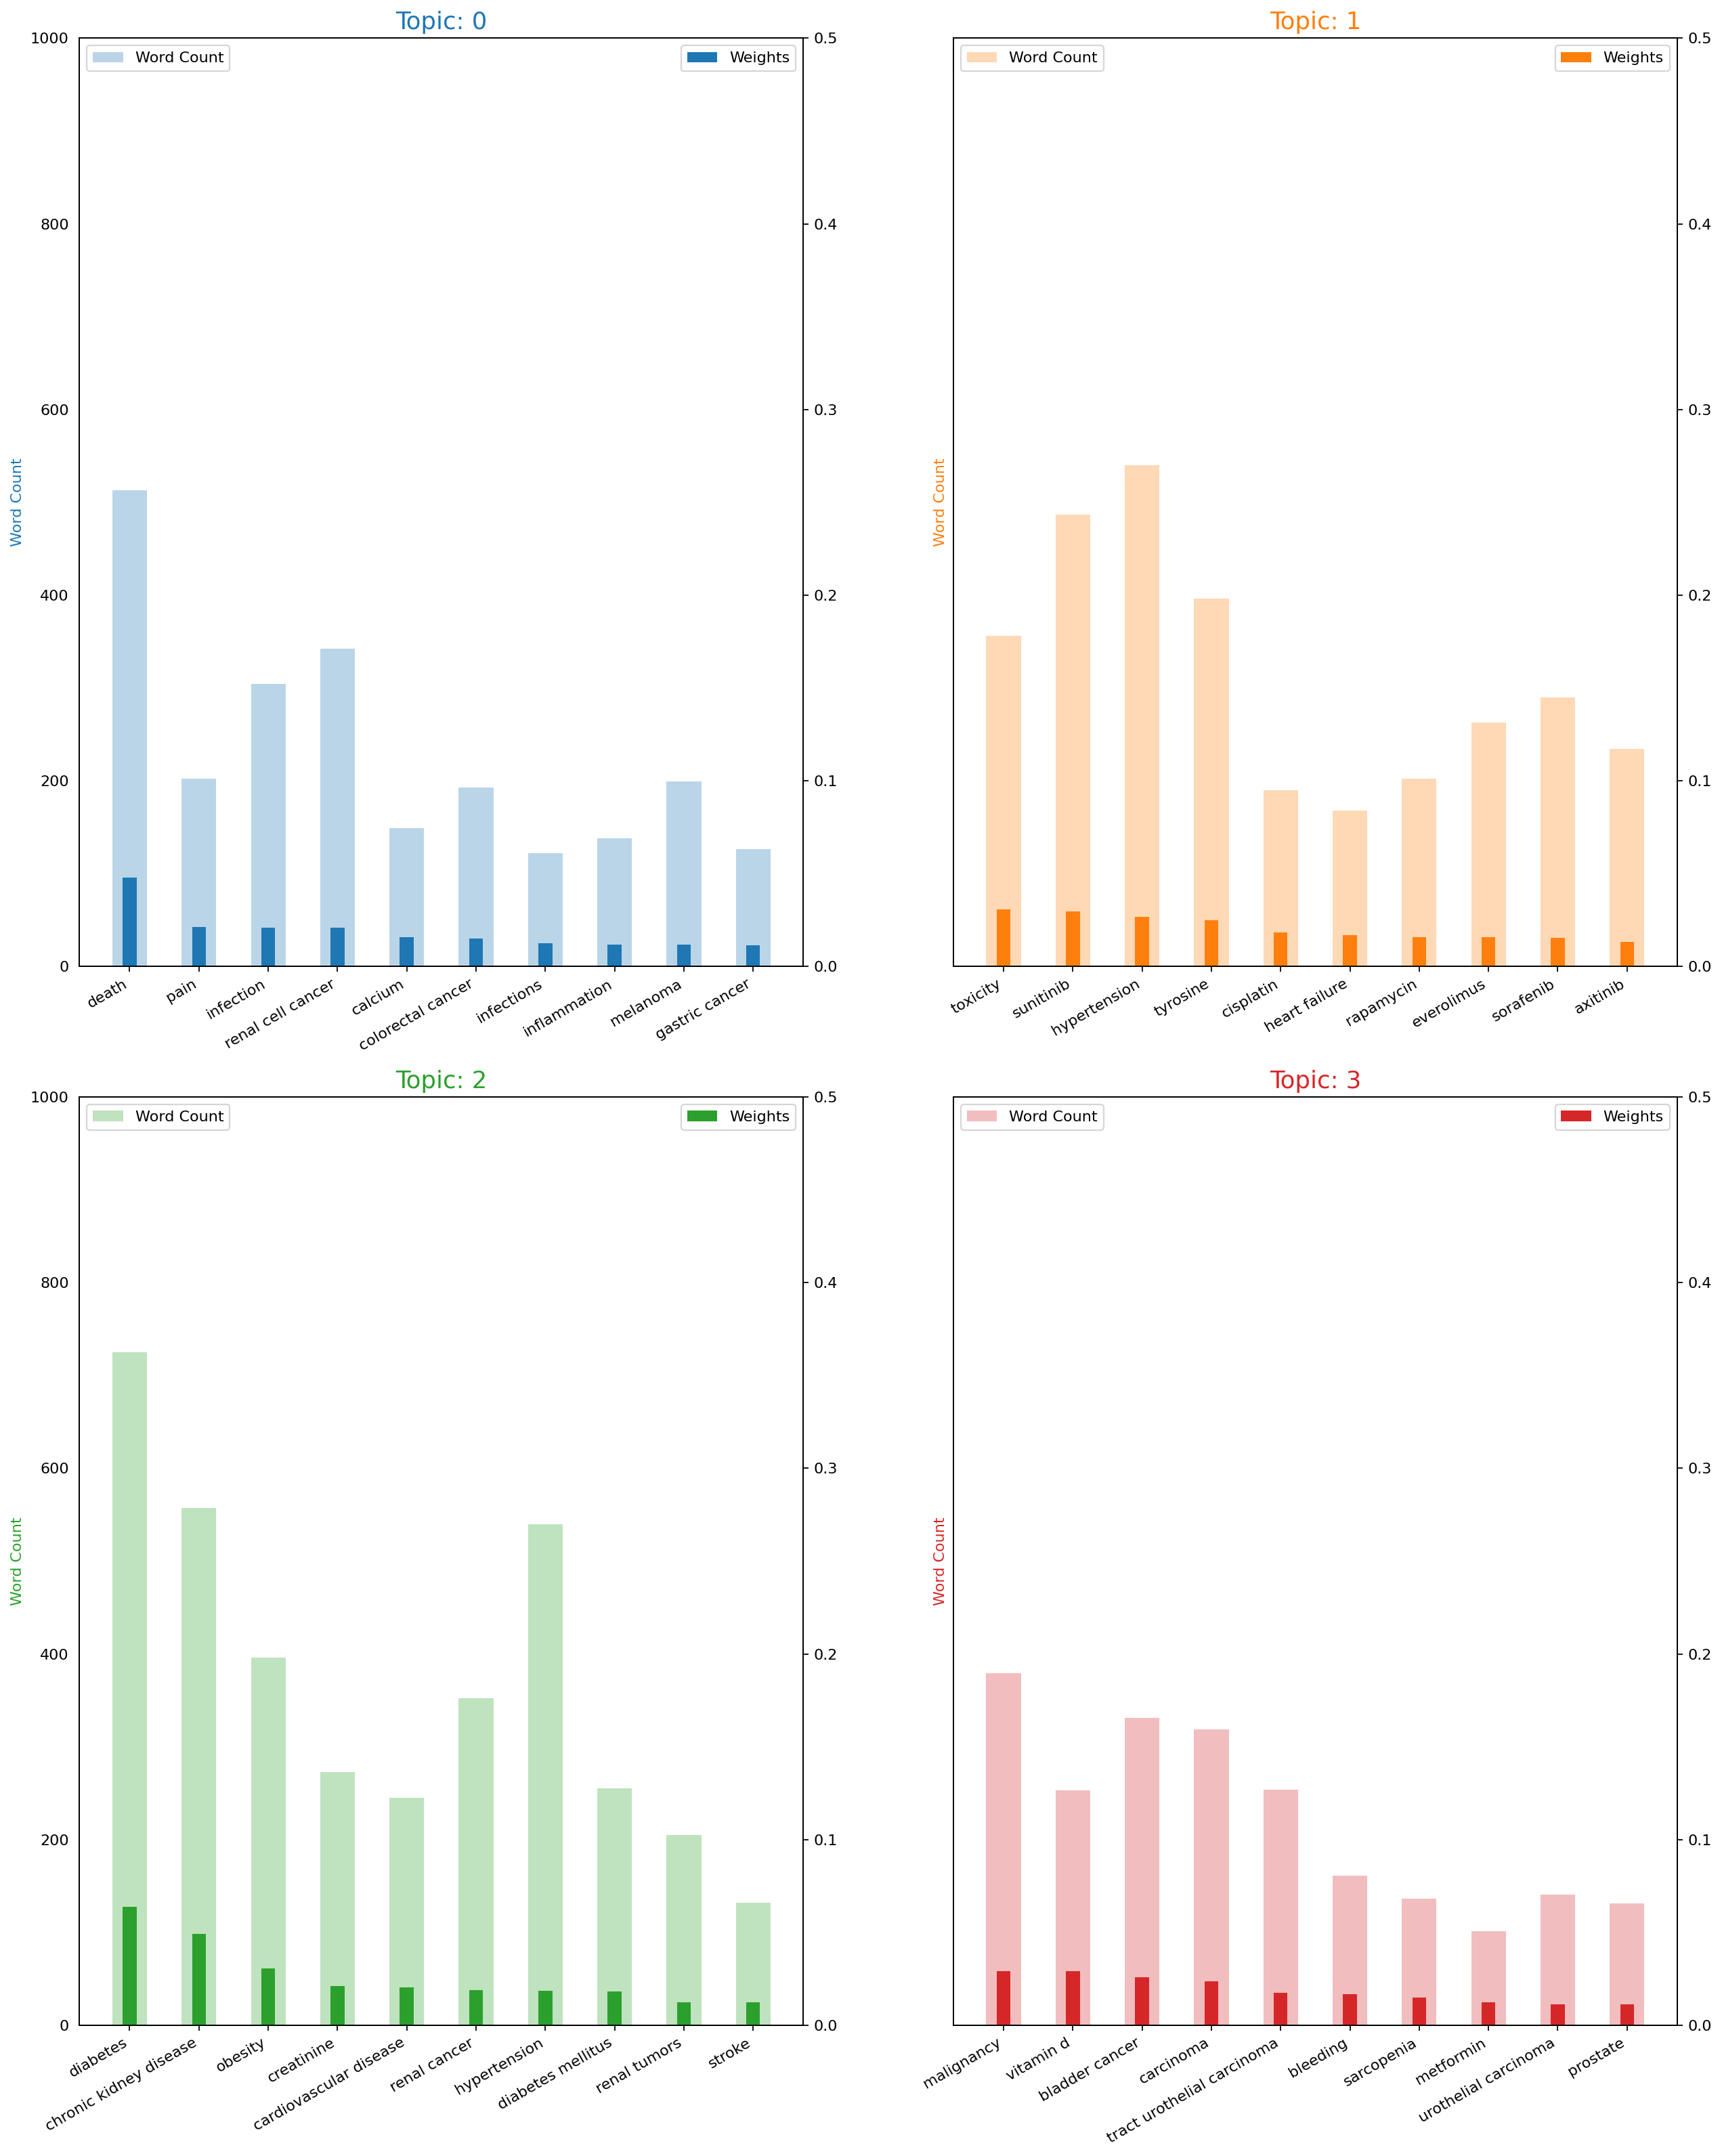

In [66]:
#@title Word importance in the topics  { form-width: "20%" }
show_wordimportance(lda_model_med, DATA)

In [67]:
#@title PyLDAVis  { form-width: "20%" }
vis = gensimvis.prepare(lda_model_med, CORPUS, dictionary=lda_model_med.id2word, sort_topics=False)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.010466 -0.238452       1        1  24.477324
1      0.167501  0.214493       2        1  26.522271
2     -0.287431  0.090842       3        1  28.157657
3      0.109464 -0.066883       4        1  20.842749, topic_info=                                            Term        Freq       Total  \
17                                      diabetes  681.000000  681.000000   
56                        chronic kidney disease  525.000000  525.000000   
178                                        death  443.000000  443.000000   
18                                       obesity  325.000000  325.000000   
110                                     toxicity  310.000000  310.000000   
..                                           ...         ...         ...   
292                                   malignancy  231.339633  316.195914   
23   renal cell carcinoma   renal cell carcinoma   87.346337  139.150031   
310                                        fever   35.618758   70.317887   
80                                     infection   37.091161  308.834800   
455                      end stage renal disease   29.574003  102.912306   

    Category  logprob  loglift  
17   Default  30.0000  30.0000  
56   Default  29.0000  29.0000  
178  Default  28.0000  28.0000  
18   Default  27.0000  27.0000  
110  Default  26.0000  26.0000  
..       ...      ...      ...  
292   Topic4  -3.5312   1.2557  
23    Topic4  -4.5052   1.1025  
310   Topic4  -5.4022   0.8880  
80    Topic4  -5.3617  -0.5513  
455   Topic4  -5.5882   0.3212  

[171 rows x 6 columns], token_table=      Topic      Freq                    Term
term                                         
2134      3  0.992142             albuminuria
249       3  0.978084                 alcohol
1064      2  0.991315                  anemia
817       2  0.991928             angiotensin
3821      4  0.990036  antithymocyte globulin
...     ...       ...                     ...
250       3  0.992980               vitamin c
489       4  0.996657               vitamin d
2965      4  0.979131    vitamin d deficiency
324       3  0.995610             weight loss
2403      1  0.985868         zoledronic acid

[153 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4])